In [3]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [12]:
# Cell 3: Database connection and query
try:
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="venomio",
        database="vpfm"
    )
    
    if connection.is_connected():       
        cursor = connection.cursor()

        cursor.execute(
            """
            SELECT
                (teamA_hxg + teamA_fxg) AS teamA_xg,
                (teamB_hxg + teamB_fxg) AS teamB_xg,
                (teamA_hxg + teamA_fxg + teamB_hxg + teamB_fxg) AS total_xg,
                home_elevation_dif,
                away_elevation_dif,
                (home_elevation_dif + away_elevation_dif) total_elevation
            FROM match_info mi
            LEFT JOIN match_detail md
                ON mi.match_id = md.match_id
            """
            )
        column_names = [desc[0] for desc in cursor.description]
        records = pd.DataFrame(cursor.fetchall(), columns=column_names)
            
except Error as e:
    print(f"Error while connecting to MySQL: {e}")
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

records

,teamA_xg,teamB_xg,total_xg,home_elevation_dif,away_elevation_dif,total_elevation
0,0.00,0.00,0.00,-174.0,-160.0,-334.0
1,0.00,0.00,0.00,-174.0,-160.0,-334.0
2,0.00,0.04,0.04,-174.0,-160.0,-334.0
3,0.00,0.06,0.06,-174.0,-160.0,-334.0
4,0.00,0.57,0.57,-174.0,-160.0,-334.0
...,...,...,...,...,...,...
20967,0.29,0.12,0.41,106.0,374.0,480.0
20968,0.06,0.21,0.27,106.0,374.0,480.0
20969,0.47,0.02,0.49,106.0,374.0,480.0
20970,0.38,0.00,0.38,106.0,374.0,480.0


In [5]:
for col in records:
    if col == "match_state":
        records = pd.get_dummies(data=records, columns=[col], drop_first=False, dtype="int64")
records.head()

,teamA_xg,teamB_xg,home_elevation_dif,away_elevation_dif
0,0.0,0.00,-174.0,-160.0
1,0.0,0.00,-174.0,-160.0
2,0.0,0.04,-174.0,-160.0
3,0.0,0.06,-174.0,-160.0
4,0.0,0.57,-174.0,-160.0


In [6]:
summary = records.describe(include="all").T
summary["mode"] = records.mode().values[0]
summary["n_unique"] = records.nunique()
summary["null_count"] = records.isnull().sum()
summary["skewness"] = records.skew(numeric_only=True)
summary["type"] = records.dtypes
#summary.drop(columns=["unique", "top", "freq"], inplace=True)
summary

,count,mean,std,min,25%,50%,75%,max,mode,n_unique,null_count,skewness,type
teamA_xg,20972.0,0.112338,0.206201,0.0,0.0,0.03,0.13,2.07,0.0,625,0,3.107817,float64
teamB_xg,20972.0,0.086142,0.178888,0.0,0.0,0.01,0.09,1.98,0.0,503,0,3.538600,float64
home_elevation_dif,20900.0,-1.008134,245.691000,-741.0,-135.0,-54.00,153.00,761.00,-53.0,134,72,0.174722,float64
away_elevation_dif,20900.0,-3.126699,553.545528,-2076.0,-204.0,-60.00,220.00,1928.00,-55.0,889,72,0.005928,float64


In [13]:
records.dropna(inplace=True)
records_corr_df = records.corr(numeric_only=True)
records_corr_df

,teamA_xg,teamB_xg,total_xg,home_elevation_dif,away_elevation_dif,total_elevation
teamA_xg,1.000000,-0.027119,0.746695,-0.000884,0.000034,-0.000254
teamB_xg,-0.027119,1.000000,0.644673,-0.009508,-0.010865,-0.010682
total_xg,0.746695,0.644673,1.000000,-0.007003,-0.007203,-0.007302
home_elevation_dif,-0.000884,-0.009508,-0.007003,1.000000,0.897958,0.950199
away_elevation_dif,0.000034,-0.010865,-0.007203,0.897958,1.000000,0.990387
total_elevation,-0.000254,-0.010682,-0.007302,0.950199,0.990387,1.000000


In [8]:
records_corr_summary = records_corr_df.describe().T
records_corr_summary.drop(columns=["count", "std", "min", "25%", "50%", "75%", "max"], inplace=True)
records_corr_summary.sort_values(by="mean", ascending=False)

,mean
home_elevation_dif,0.471891
away_elevation_dif,0.471782
teamA_xg,0.243008
teamB_xg,0.238127


Correlation between total_xg and total_elevation: -0.007


C:\Users\markg\AppData\Local\Temp\ipykernel_21328\3279518582.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(records[xname], records[yname],# dot sizes based on teamA_xg


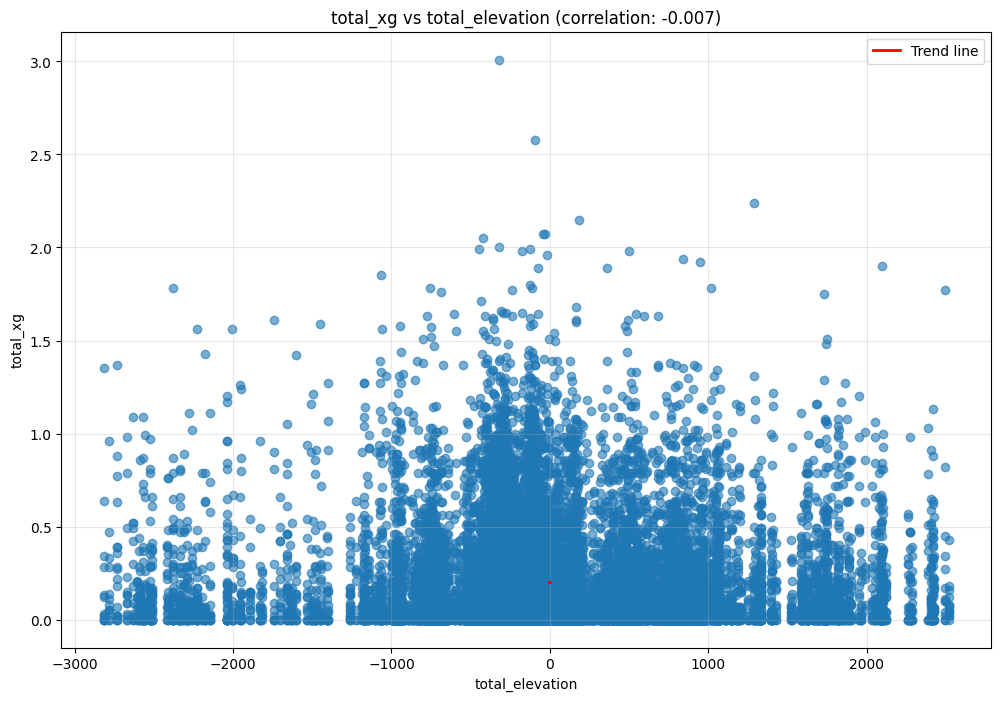

In [17]:
yname = "total_xg"
xname = "total_elevation"

y = records[yname]
x = records[xname]

plt.figure(figsize=(12, 8))

# Correlation analysis
correlation = records[xname].corr(records[yname])
print(f"Correlation between {yname} and {xname}: {correlation:.3f}")

# Simple regression plot
scatter = plt.scatter(records[xname], records[yname],# dot sizes based on teamA_xg
                     alpha=0.6, 
                     cmap='viridis')  # color map

# Add regression line
try:
    z_coef = np.polyfit(records[xname], records[yname], 1)
    p = np.poly1d(z_coef)
    plt.plot(records[yname], p(records[yname]), "r-", linewidth=2, label='Trend line')
    plt.legend()
except:
    print("Could not fit regression line")

plt.xlabel(xname)
plt.ylabel(yname)
plt.title(f'{yname} vs {xname} (correlation: {correlation:.3f})')
plt.grid(True, alpha=0.3)
plt.show()